In [7]:
import os
import cv2
import keras
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.4


In [2]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [3]:
train_image_files_path = "/keras2production/fruits/Training/"
train_images = !find $train_image_files_path -type f -name "*.jpg"

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [4]:
inet_model = inception_v3.InceptionV3()

96116736/96112376 [==============================] - 20s 0us/step


In [5]:
def classify_image(image):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # images need to be numpy arrays
    image = image_utils.load_img(image, target_size=(299, 299))
    image = image_utils.img_to_array(image)

    # expand the dimensions
    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    image = preprocess_input(image)
        
    preds = inet_model.predict(image)
    res = decode_predictions(preds, top=3)
    
    for (i, (imagenetID, label, prob)) in enumerate(res[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

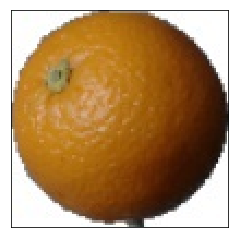

40960/35363 [==================================] - 0s 2us/step
1. orange: 87.94%
2. lemon: 4.21%
3. strawberry: 0.35%


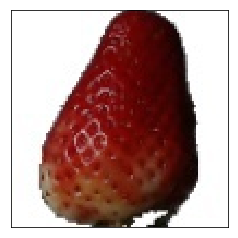

1. strawberry: 99.37%
2. cowboy_boot: 0.04%
3. trifle: 0.02%


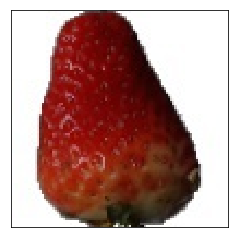

1. strawberry: 99.69%
2. cowboy_boot: 0.03%
3. sarong: 0.01%


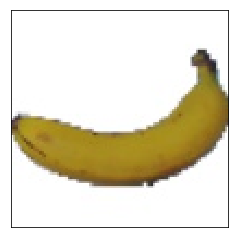

1. banana: 99.85%
2. eel: 0.03%
3. neck_brace: 0.01%


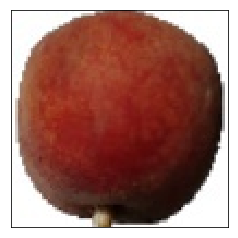

1. lemon: 21.80%
2. fig: 9.79%
3. Granny_Smith: 6.75%


In [8]:
num = 5
train_images_r = random.sample(train_images, num)
for i in range(num):
    classify_image(train_images_r[i])

In [9]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_utils.load_img(img_path, target_size=(299, 299))
        x = image_utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [10]:
images = transform_img_fn([os.path.join('test_images', 'Banana', 'Banana_wiki.jpg')])

('n07753592', 'banana', 0.99999297)
('n07747607', 'orange', 1.1464743e-06)
('n07716906', 'spaghetti_squash', 2.1448774e-07)
('n04548280', 'wall_clock', 1.8645702e-07)
('n01728572', 'thunder_snake', 9.827431e-08)


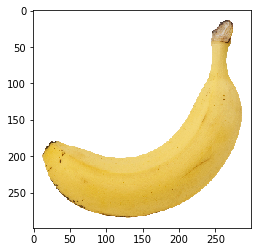

In [11]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [12]:
df = pd.DataFrame(preds)
df.idxmax(axis=1)

0    954
dtype: int64

In [13]:
explainer = lime_image.LimeImageExplainer()

In [14]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels# Hide  
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 7min 35s, sys: 54.6 s, total: 8min 29s
Wall time: 2min 22s


In [15]:
type(explanation)

lime.lime_image.ImageExplanation

In [16]:
from skimage.segmentation import mark_boundaries

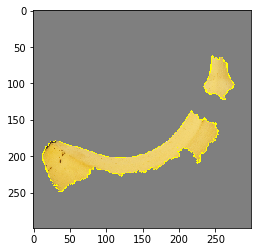

In [17]:
temp, mask = explanation.get_image_and_mask(954, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

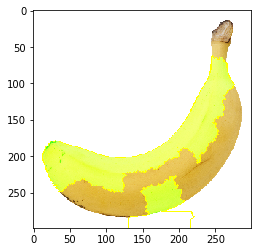

In [18]:
temp, mask  =  explanation.get_image_and_mask(954, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))